<a href="https://colab.research.google.com/github/chetannitk/BeerDataScienceAssignment/blob/master/notebooks/05-sklearn-k-mean-clustering-to-find-similar-beer-drinkers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert alert-success">
    <h1> Beer Data Science Assignment <br/></h1>
    Knowledge Graph
</div>


In [1]:
from IPython.display import HTML
import pandas as pd
import os
import numpy as np
from datetime import datetime
import wordcloud
import warnings
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
warnings.filterwarnings('ignore')

BASE_PATH = "../"
INPUT_DATA_PATH = os.path.join(BASE_PATH, "data/raw/BeerDataScienceProject.csv")

/home/chetan/anaconda3/envs/chetan_ml/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  # Remove the CWD from sys.path while we load stuff.


In [2]:
## Upload BeerDataScienceProject.csv file from local system.
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data/BeerDataScienceProject.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
!ls -lrt /tmp

In [4]:
import io
df_beer_raw = pd.read_csv(INPUT_DATA_PATH, encoding="ISO-8859-1")

In [5]:
df_beer_raw.shape

(528870, 13)

In [6]:
df_beer_raw.dtypes

beer_ABV              float64
beer_beerId             int64
beer_brewerId           int64
beer_name              object
beer_style             object
review_appearance     float64
review_palette        float64
review_overall        float64
review_taste          float64
review_profileName     object
review_aroma          float64
review_text            object
review_time             int64
dtype: object

### Data Cleaning
```In the below cell we can see that there are some columns where data is missing. 
   We need to remove those data points from our data set.
```

In [7]:
df_beer_raw.isna().sum()

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64

In [8]:
df_beer = df_beer_raw.dropna()

In [9]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
beer_ABV              508358 non-null float64
beer_beerId           508358 non-null int64
beer_brewerId         508358 non-null int64
beer_name             508358 non-null object
beer_style            508358 non-null object
review_appearance     508358 non-null float64
review_palette        508358 non-null float64
review_overall        508358 non-null float64
review_taste          508358 non-null float64
review_profileName    508358 non-null object
review_aroma          508358 non-null float64
review_text           508358 non-null object
review_time           508358 non-null int64
dtypes: float64(6), int64(3), object(4)
memory usage: 54.3+ MB


In [10]:
df_beer = df_beer.reset_index()
df_beer['id'] = df_beer.index

## Data Changes in Raw and Clean dataset

In [11]:
print("Raw data size: ", df_beer_raw.shape[0])
print("Clean data size: ", df_beer.shape[0])
print("Data points difference: ", df_beer_raw.shape[0]-df_beer.shape[0])

Raw data size:  528870
Clean data size:  508358
Data points difference:  20512


## Knowledge Graph Creation using Review-text

In [36]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en')
neuralcoref.add_to_pipe(nlp)


def entity_pairs(text, coref=True):
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters
    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = list()
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span) for span in spans]
        dep = [token.dep_ for token in sent]
        if (dep.count('obj')+dep.count('dobj'))==1 \
                and (dep.count('subj')+dep.count('nsubj'))==1:
            for token in sent:
                if token.dep_ in ('obj', 'dobj'):  # identify object nodes
                    subject = [w for w in token.head.lefts if w.dep_
                               in ('subj', 'nsubj')]  # identify subject nodes
                    if subject:
                        subject = subject[0]
                        # identify relationship by root dependency
                        relation = [w for w in token.ancestors if w.dep_ == 'ROOT']  
                        if relation:
                            relation = relation[0]
                            # add adposition or particle to relationship
                            if relation.nbor(1).pos_ in ('ADP', 'PART'):  
                                relation = ' '.join((str(relation),
                                        str(relation.nbor(1))))
                        else:
                            relation = 'unknown'
                        subject, subject_type = refine_ent(subject, sent)
                        token, object_type = refine_ent(token, sent)
                        ent_pairs.append([str(subject), str(relation), str(token),
                                str(subject_type), str(object_type)])
    filtered_ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(x) == '' for x in sublist)]
    pairs = pd.DataFrame(filtered_ent_pairs, columns=['subject',
                         'relation', 'object', 'subject_type',
                         'object_type'])
    #print('Entity pairs extracted:', str(len(filtered_ent_pairs)))
    return pairs


def refine_ent(ent, sent):
    unwanted_tokens = (
        'PRON',  # pronouns
        'PART',  # particle
        'DET',  # determiner
        'SCONJ',  # subordinating conjunction
        'PUNCT',  # punctuation
        'SYM',  # symbol
        'X',  # other
        )
    ent_type = ent.ent_type_  # get entity type
    if ent_type == '':
        ent_type = 'NOUN_CHUNK'
        ent = ' '.join(str(t.text) for t in
                nlp(str(ent)) if t.pos_
                not in unwanted_tokens and t.is_stop == False)
    elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
        t = ''
        for i in range(len(sent) - ent.i):
            if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                t += ' ' + str(ent.nbor(i))
            else:
                ent = t.strip()
                break
    return ent, ent_type

In [37]:
review_data = df_beer['review_text'].tolist()
pairs = [".".join(review_data[i:i+10]) for i in range(0,len(review_data),10)]
pairs = review_data


In [38]:
frames = []
for data in tqdm_notebook(pairs):
    try:
        df_temp = entity_pairs(data)
        frames.append(df_temp)
    except Exception as e:
        pass



IndexError: [E042] Error accessing doc[4].nbor(1), for doc of length 5.

In [39]:
df_res = pd.concat(frames)

In [40]:
df_res.head(100)

subject     relation  \
0                                               beer        pours   
1                                     flavor profile   replicates   
0                                               beer      reminds   
0                                               beer          has   
0                                            Caramel        round   
0                                              taste      follows   
0                                                 O-        works   
0                                              taste       follow   
1                                             kisser          say   
0                                          smokiness      carries   
0                                               beer          has   
0                             Caramel malt sweetness     provides   
1                                               Nice    lingering   
0                                              malts         have   
0                                               beer          had   
0                                               hint         adds   
1                                         Sweet malt        start   
0                                   Deep cherry body         head   
1                                 Sweet stone fruits          add   
0                                             Simple        takes   
1                                       Sweet fruity        malty   
2                                    Fine smoked ham   carmelized   
0                                             Flavor   starts out   
0                                               beer        pours   
1                                            flavors      include   
0                            baked caramel sweetness         adds   
0                                  nice surprise tap      grabbed   
0                                              Light       bodied   
0                                          maltiness   mixed with   
0                                               feel      matched   
..                                               ...          ...   
0                          exceptionally creamy head     retained   
1                                       bold caramel          hit   
2                                  Lemon orange oils      make up   
3                                               body    feel with   
0                                               beer      took on   
1                                 T. lovely hop bite  accompanies   
0                                       Careful pour     produces   
1                                 Citrus fruit aroma      provide   
2                                              Light       bodied   
0                                              12 oz          can   
0                                              honey       kissed   
1                                          M Perfect       yields   
0                                            T Taste      follows   
0                                         Nice taste      take on   
0                                              Taste          has   
0                                          Agitation       brings   
0                             Bubblebath like lacing      trailed   
1                                             grains         form   
2   Caldera Pale Ale active soft rolling carbonation     massaged   
0      Crisp mild CO2 light caramel mild sweet fruit       smooth   
1                                         Refreshing        clean   
0                           Flowery citric hop aroma      screams   
1                                          benchmark        shows   
0                                     freshness date       Poured   
0                                      peppery spice          are   
0                                            big sip     delivers   
0                                          

In [41]:
df_res[df_res.subject_type=='ORG']

subject   relation                          object  \
0  The Caldera Pale Ale        had    tight bubble lacing patterns   
1  The Caldera Pale Ale        had                  powerful aroma   
2  The Caldera Pale Ale        had                 good sharp bite   
1               Caldera      Seems             west coast approach   
0            bitterness  dominates                           aroma   
0          2004 VINTAGE      found                 delicious glory   
0            Bitterness   sustains                      Bitterness   
0             A. Copper   coloured                       clear ale   
0    Tangerine, lemon &       fill                       Tangerine   
0               Caldera       made            truly remarkable IPA   
0            Grapefruit   dominate                            bold   
0               The IPA    appears  super clear golden amber color   
0           Caldera IPA     boasts             kinda bright orange   
0       T - Caldera IPA     tastes                       delicious   

  subject_type object_type  
0          ORG  NOUN_CHUNK  
1          ORG  NOUN_CHUNK  
2          ORG  NOUN_CHUNK  
1          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK  
0          ORG         ORG  
0          ORG  NOUN_CHUNK  
0          ORG         GPE  
0          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK  
0          ORG  NOUN_CHUNK

In [42]:
df_res.object_type.value_counts()

NOUN_CHUNK    282
PERSON          4
ORG             2
GPE             2
QUANTITY        1
MONEY           1
LOC             1
Name: object_type, dtype: int64

In [43]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

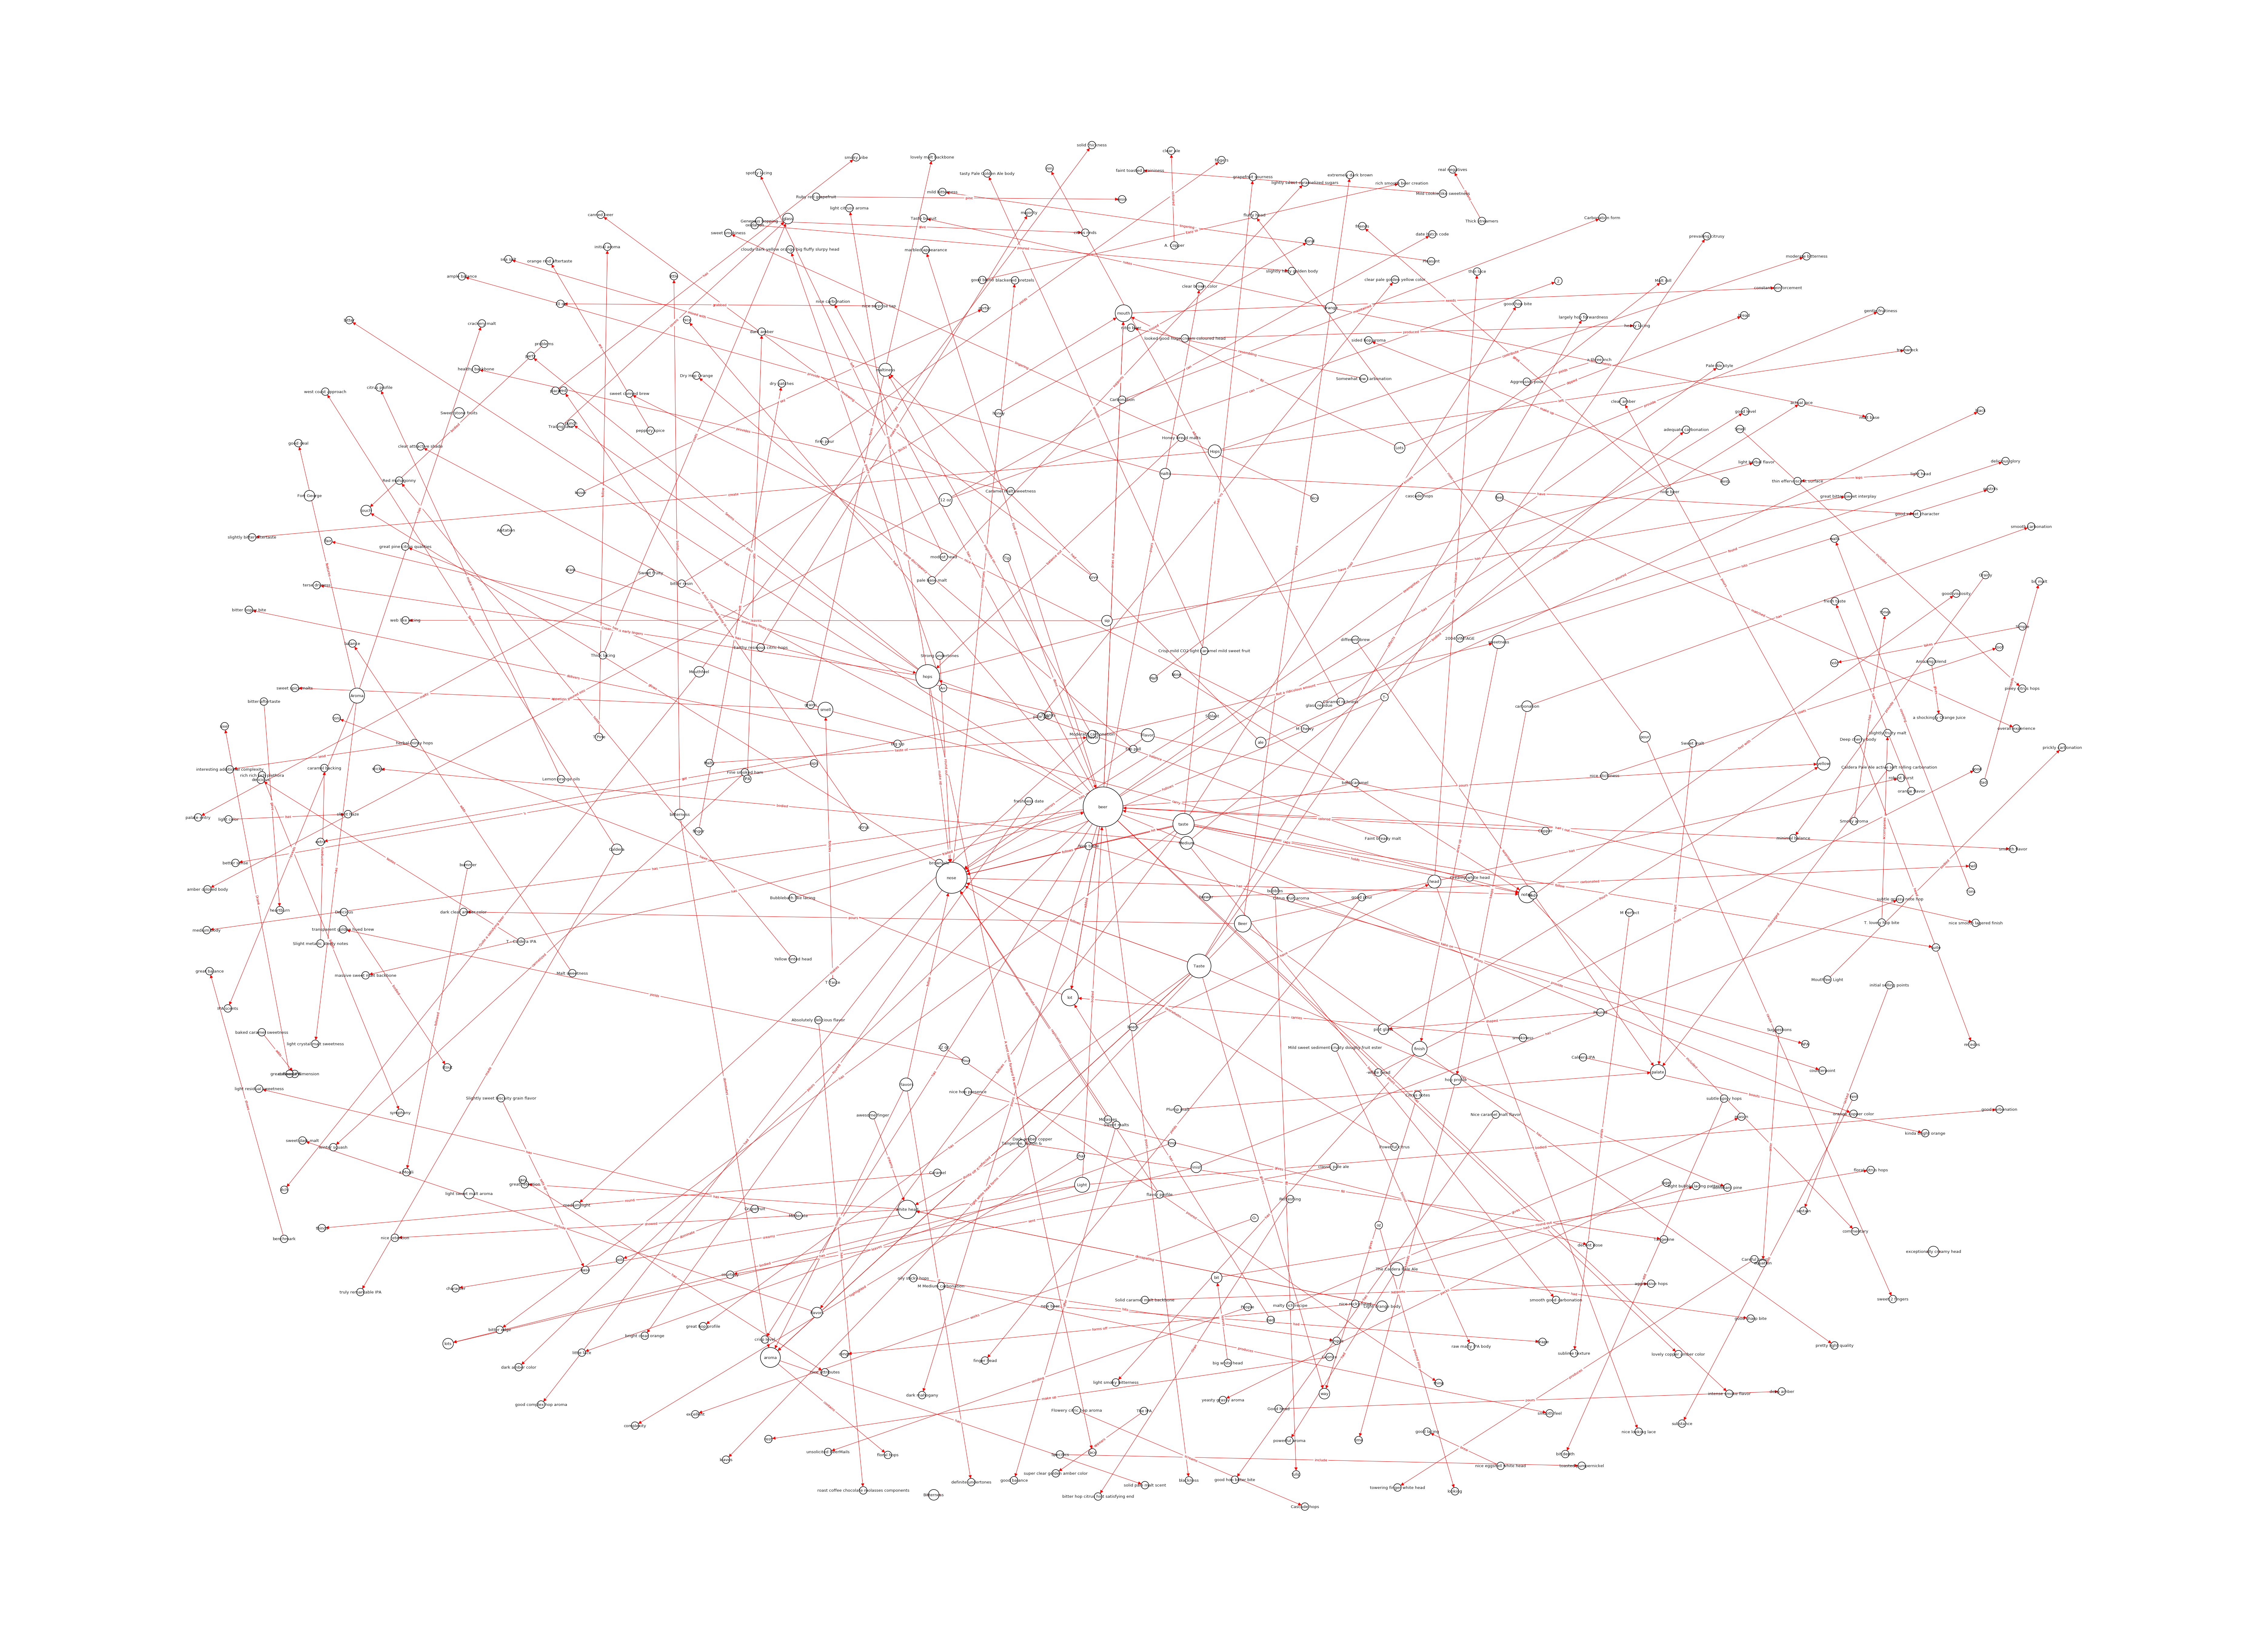

In [44]:
draw_kg(df_res)


In [47]:
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))),
                    pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    #print(k_graph.out_edges(data=False))
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels,
                                font_color='red')
    plt.axis('off')
    plt.show()

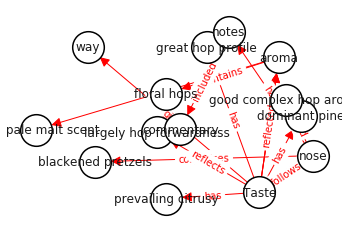

In [62]:
filter_graph(df_res, 'Taste')
